In [1]:
# import required modules
from sbi.neural_nets import posterior_nn

# import the different choices of pre-configured embedding networks
from sbi.neural_nets.embedding_nets import SpectralConvEmbedding

/Users/lsmuhle/anaconda3/envs/sbi_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import torch

from sbi import analysis, utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

seed = 0
torch.manual_seed(seed);

In [3]:
def simulator_model(parameter, return_points=False):
    """Simulator model with two-dimensional input parameter and 1024-D output

    This simulator serves as a basic example for using a neural net for learning
    summary features. It has only two input parameters but generates
    high-dimensional output vectors. The data is generated as follows:
        (-) Input:  parameter = [r, phi] (1) Generate 100 two-dimensional
        points centered around (r cos(phi),r sin(phi))
            and perturbed by a Gaussian noise with variance 0.01
        (2) Create a grayscale image I of the scattered points with dimensions
            32 by 32
        (3) Perturb I with an uniform noise with values betweeen 0 and 0.2
        (-) Output: I

    Parameters
    ----------
    parameter : array-like, shape (2)
        The two input parameters of the model, ordered as [r, phi]
    return_points : bool (default: False)
        Whether the simulator should return the coordinates of the simulated
        data points as well

    Returns
    -------
    I: torch tensor, shape (1, 1024)
        Output flattened image
    (optional) points: array-like, shape (100, 2)
        Coordinates of the 2D simulated data points

    """
    r = parameter[0]
    phi = parameter[1]

    sigma_points = 0.10
    npoints = 100
    points = []
    for _ in range(npoints):
        x = r * torch.cos(phi) + sigma_points * torch.randn(1)
        y = r * torch.sin(phi) + sigma_points * torch.randn(1)
        points.append([x, y])
    points = torch.as_tensor(points)

    nx = 3 #channels
    ny = 32
    sigma_image = 0.20
    im = torch.zeros(nx, ny)
    for point in points:
        pi = int((point[0] - (-1)) / ((+1) - (-1)) * nx)
        pj = int((point[1] - (-1)) / ((+1) - (-1)) * ny)
        if (pi < nx) and (pj < ny):
            im[pi, pj] = 1
    im = im + sigma_image * torch.rand(nx, ny)

    if return_points:
        return im.reshape(1, -1), points
    else:
        return im.reshape(1, -1)

Text(0.5, 1.0, 'noisy observed data (gray image with 32 x 3 pixels)')

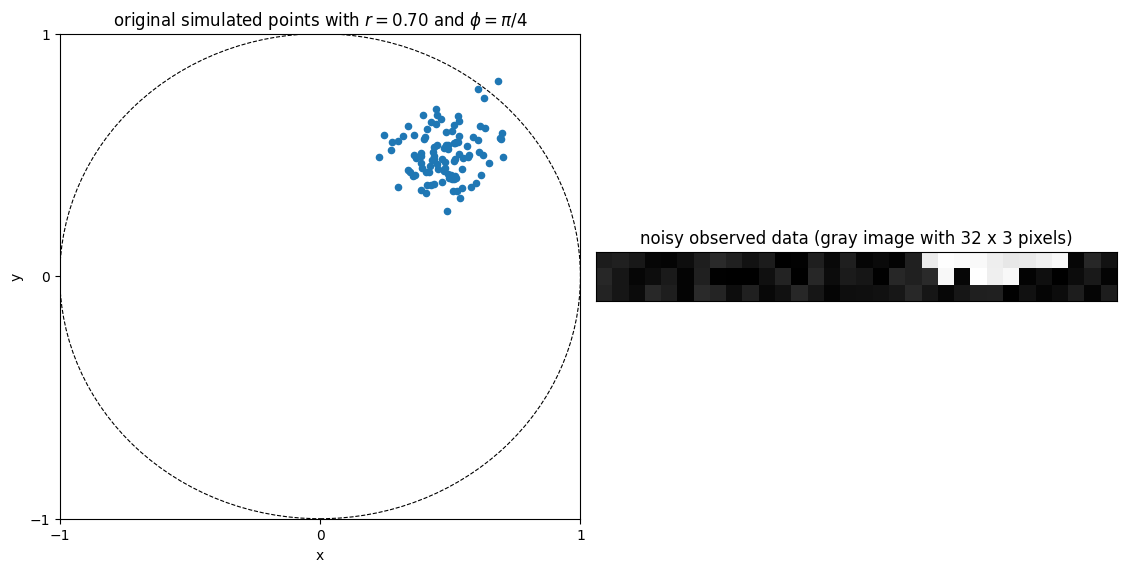

In [4]:
# simulate samples
true_parameter = torch.tensor([0.70, torch.pi / 4])
x_observed, x_points = simulator_model(true_parameter, return_points=True)

# plot the observation
fig, ax = plt.subplots(
    facecolor="white", figsize=(11.15, 5.61), ncols=2, constrained_layout=True
)
circle = plt.Circle((0, 0), 1.0, color="k", ls="--", lw=0.8, fill=False)
ax[0].add_artist(circle)
ax[0].scatter(x_points[:, 0], x_points[:, 1], s=20)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_xlim(-1, +1)
ax[0].set_xticks([-1, 0.0, +1.0])
ax[0].set_ylim(-1, +1)
ax[0].set_yticks([-1, 0.0, +1.0])
ax[0].set_title(r"original simulated points with $r = 0.70$ and $\phi = \pi/4$")
ax[1].imshow(x_observed.view(3, 32), origin="lower", cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("noisy observed data (gray image with 32 x 3 pixels)")

In [5]:

embedding_net = SpectralConvEmbedding(n_points=32, modes=5, in_channels = 3, conv_channels=10, num_layers=4)



In [6]:
# set prior distribution for the parameters
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 2 * torch.pi])
)

# make a SBI-wrapper on the simulator object for compatibility
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator_model, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [7]:

# instantiate the neural density estimator
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

# setup the inference procedure with NPE
inferer = NPE(prior=prior, density_estimator=neural_posterior)

In [8]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 306.85it/s]


In [9]:
### Reshape x to fit for our set up (batchsize, points, channels)

x.shape # conv_channels, 1??, 3* 32 # why flattend?
x_2d = x.squeeze(1)
x_2d.shape

torch.Size([1000, 96])

In [10]:
density_estimator = inferer.append_simulations(theta, x).train(training_batch_size=100)

 Neural network successfully converged after 181 epochs.

In [11]:
posterior = inferer.build_posterior(density_estimator)

In [12]:
# generate posterior samples
true_parameter = torch.tensor([0.50, torch.pi / 4])
x_observed = simulator_model(true_parameter)
samples = posterior.set_default_x(x_observed).sample((50000,))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples: 100%|██████████| 50000/50000 [00:00<00:00, 194405.93it/s]


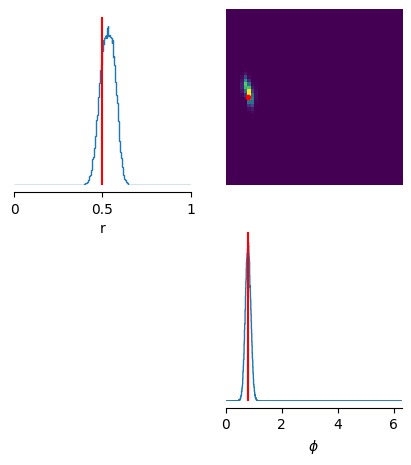

In [13]:
# create the figure
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter,
    labels=["r", r"$\phi$"],
    limits=[[0, 1], [0, 2 * torch.pi]],
    fig_kwargs=dict(
        points_colors="r",
        points_offdiag={"markersize": 6},
    ),
    figsize=(5, 5),
)